In [529]:
# Imports all the required packages
import os
import argparse
import numpy as np
import os.path as osp
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_geometric.data import (InMemoryDataset, download_url, extract_zip,Data)

import torch
#from torcheval.metrics import R2Score # To be implemented
import torch.nn as nn
import torch.nn.functional as F
from rdkit.Chem import DataStructs
from torch_geometric.loader import DataLoader

import torch.nn.functional as F
from torch.nn import Linear
from torch.nn import BatchNorm1d
import torch.optim as optim
from torch_geometric.nn import GCNConv,GraphConv,NNConv
from torch_geometric.nn import global_add_pool,knn_graph

try:
    import rdkit
    from rdkit import Chem
    from rdkit.Chem import AllChem
    from rdkit import rdBase
    from rdkit.Chem.rdchem import HybridizationType
    from rdkit import RDConfig
    from rdkit.Chem import ChemicalFeatures
    from rdkit.Chem.rdchem import BondType as BT
    from rdkit.Chem import Draw
    rdBase.DisableLog('rdApp.error')
except ImportError:
    print("rdkit = None")

In [530]:
# Model definition used for regression

class GCNlayer(nn.Module):
    
    def __init__(self, n_features, conv_dims, concat_dim, dropout):
        super(GCNlayer, self).__init__()
        self.n_features = n_features
        self.conv_dims = conv_dims
        self.concat_dim =  concat_dim
        self.dropout = dropout
        
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.gru=nn.ModuleList()
        #args.conv_dims=[args.n_features,128,512,4092]
        self.lin0 = torch.nn.Linear(args.n_features, self.conv_dims[0]) # Changed from 128
        for i in range(len(self.conv_dims)-1):
            kk = nn.Sequential(Linear(6, self.conv_dims[i+1]), nn.ReLU(), Linear(self.conv_dims[i+1], self.conv_dims[i+1]*self.conv_dims[i+1]))
            conv = NNConv(self.conv_dims[i], self.conv_dims[i+1],kk,aggr='add')
            self.convs.append(conv)
            bn = BatchNorm1d(self.conv_dims[i+1])
            self.bns.append(bn)
            self.gru.append(nn.GRU(self.conv_dims[i+1], self.conv_dims[i+1])) # Changed
        self.conv_last = GraphConv(self.conv_dims[-1],self.conv_dims[-1])  # Last layer
        self.bn_last = BatchNorm1d(self.concat_dim)
        
    def forward(self, data):
        x, edge_index,edge_attr= data.x, data.edge_index,data.edge_attr # Changed . added edge_attr
        out = F.relu(self.lin0(x))
        h = out.unsqueeze(0)
        for i in range(len(self.convs)):
            m = F.relu(self.convs[i](out, edge_index,edge_attr)) # Changed . added edge_attr
            m = self.bns[i](m)
            out, h = self.gru[i](m.unsqueeze(0), h)  # Changed here. Added [i]
            out = out.squeeze(0)

        x = F.relu(self.conv_last(out, edge_index))# Changed . added edge_attr
        x = self.bn_last(x)
        x = global_add_pool(x,batch=data.batch)   #global_add_pool  cHANGED
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x
    
class FClayer(nn.Module):
    
    def __init__(self, concat_dim, pred_dims, out_dim, dropout):
        super(FClayer, self).__init__()
        self.concat_dim = concat_dim
        self.pred_dims = pred_dims
        self.out_dim = out_dim
        self.dropout = dropout

        self.fcs = nn.ModuleList()
        self.bns = nn.ModuleList()
        # Linear layer has bias default=True
        for i in range(len(self.pred_dims)-1):
            fc = Linear(self.pred_dims[i], self.pred_dims[i+1])
            self.fcs.append(fc)
            bn = BatchNorm1d(self.pred_dims[i+1])
            self.bns.append(bn)
        self.fc_last = Linear(self.pred_dims[-1], self.out_dim)
    
    def forward(self, data):
        x = data
        for i in range(len(self.fcs)):
            x = F.relu(self.fcs[i](x))
            x = self.bns[i](x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc_last(x)
        return x

# Model definition  
class GCN_Model_reg(nn.Module):
    def __init__(self, args):
        super(GCN_Model_reg, self).__init__()
        
        # Convolutional Layer call
        self.conv = GCNlayer(args.n_features,args.conv_dims,args.concat_dim,args.dropout)

        # Fully connected layer call
        self.fc = FClayer(args.concat_dim,args.pred_dims,args.out_dim,args.dropout)
        
    def forward(self, data):
        x = self.conv(data) # Calling the convolutional layercpu
        x = self.fc(x) # Calling the Fully Connected Layer
        return x

In [531]:
# pytorch will be run on cpu
seed=200
paser = argparse.ArgumentParser()
args = paser.parse_args("")
np.random.seed(200)
torch.manual_seed(seed)
device=input("Enter cuda or cpu for device type")
device = torch.device(device)
#'cuda' if torch.cuda.is_available() else
device

device(type='cuda')

In [532]:
# Inputs required by the program
args.epoch = 400
args.lr = 0.0001
args.optim = 'Adam'
args.step_size = 25
args.gamma = 0.8
args.dropout = 0 # Tested for 0.2 but max r2 got 0.874. For 0.1 I got 0.897
args.n_features = 30  # Mass added else 29. Without atomic mass r2 0.899
args.concat_dim=128
args.conv_dims=[128,128,128] # Removed 1 layer
args.pred_dims=[128,512,128]
args.out_dim = 1

In [533]:
# encoding of all variables

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
 
def get_intervals(l):
    """For list of lists, gets the cumulative products of the lengths"""
    intervals = len(l) * [0]
    # Initalize with 1
    intervals[0] = 1
    for k in range(1, len(l)):
        intervals[k] = (len(l[k]) + 1) * intervals[k - 1]
    return intervals

def safe_index(l, e):
    """Gets the index of e in l, providing an index of len(l) if not found"""
    try:
        return l.index(e)
    except:
        print("Add value to list of length {}".format(len(l)))
        return len(l)

In [534]:
# Atom features

possible_atom_list = ['H','C', 'O', 'F','N','Cl','P','S','Si','Br','I']  # Atomic symbol 11

aromatic=[0,1] # Aromatic 1
isring=[0,1]   # Ring 1
possible_numH_list = [0, 1, 2, 3, 4] # Total Number of bonded hydrogen atoms possible 5
num_bonds = [0, 1, 2, 3, 4, 5]  # Total Number of Hs a carbon can bond / Total number of bonds an atom make 6
possible_formal_charge_list = [-4,-3, -2, -1, 0, 1, 2, 3, 4]

# sp3d is removed because it doesnot vary according to the paper . Hybridization 4
possible_hybridization_list = [Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,Chem.rdchem.HybridizationType.SP3,Chem.rdchem.HybridizationType.SP3D2]

# storing all the features in a detailed list
reference_lists = [possible_atom_list, possible_numH_list,possible_formal_charge_list, num_bonds,aromatic,isring,possible_hybridization_list]

intervals = get_intervals(reference_lists)
print(intervals)

[1, 6, 60, 420, 1260, 3780, 18900]


- Total number of atom features used here is = 29

In [535]:
# Concatenate the entire feature list
def get_feature_list(atom):
    features = 5 * [0]
    features[0] = safe_index(possible_atom_list, atom.GetSymbol())
    features[1] = safe_index(possible_numH_list, atom.GetTotalNumHs())
    features[2] = safe_index(num_bonds, atom.GetImplicitValence())
    features[3] = safe_index(possible_formal_charge_list, atom.GetFormalCharge())    
    features[4] = safe_index(possible_hybridization_list, atom.GetHybridization())
    return features

In [536]:
def atom_features(atom,bool_id_feat=False,explicit_H=False):
    from rdkit import Chem
    results = np.array(one_of_k_encoding_unk(atom.GetSymbol(),possible_atom_list) + 
                           one_of_k_encoding_unk(atom.GetImplicitValence(), num_bonds) + 
                           [atom.GetFormalCharge()] + 
                           one_of_k_encoding_unk(atom.GetHybridization(), possible_hybridization_list) + 
                           [atom.GetIsAromatic()]+[atom.IsInRing()]+[atom.GetAtomicNum()])  # Atomic mass added  atom.GetAtomicNum() r2=0.907
    if not explicit_H:
        results = np.array(results.tolist() + one_of_k_encoding_unk(atom.GetTotalNumHs(),possible_numH_list))  # include neighbouring Hs
    return np.array(results)

In [537]:
# Bond Features

def bond_features(bond):
    from rdkit import Chem
    bt = bond.GetBondType()
    bond_feats = [bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
                  bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
                  bond.GetIsConjugated(),bond.IsInRing()]
    
    # Include stereo bond features as it effects the boiling point
    #bond_feats = bond_feats + one_of_k_encoding_unk(str(bond.GetStereo()),["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
    return np.array(bond_feats)


- In the above bond features we have commented the stereo feature because we have seen that the smiles string has not been encoded to represent the information of the stereo state of the chemical formula.

In [538]:
# Create  atom pair of two connected molecules to pass messages

def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[],[]]
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
    return res

# create a graph data structure comprising of x=node_f, edge_index = bond pair info, 
# Here we are taking converted molecule from smiles as string
def mol2vec(mol):
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()
    node_f= [atom_features(atom) for atom in atoms]
    edge_index = get_bond_pair(mol)
    edge_attr = [bond_features(bond) for bond in bonds]

    for bond in bonds:
        edge_attr.append(bond_features(bond))
        
    # Graph data to be used
    # changes made in edge index format 
    data = Data(x=torch.tensor(node_f, dtype=torch.float),edge_index=torch.tensor(edge_index, dtype=torch.long),edge_attr=torch.tensor(edge_attr,dtype=torch.float))
    
    #print(data)
    return data,edge_attr,node_f

In [539]:
# Return mol info
def make_mol(df):
    mols = {}
    for i in range(df.shape[0]):
        mols[Chem.MolFromSmiles(df['Smiles'].iloc[i])] = df['Tb'].iloc[i]
    return mols

In [540]:
# Convert the dataset with X values and y values to be trained/tested
def make_vec(mols):
    X = []
    for m in mols.keys():
        s,_,_=mol2vec(m) 
        X.append(s)
    for i, data in enumerate(X):
        y = list(mols.values())[i]
        data.y = torch.tensor([y], dtype=torch.float)
    return X

In [541]:
# Pca on graph data
#import umap
from sklearn.decomposition import PCA
def tsne_g(n,e):
    #print(e[0],e[1])
    model=PCA(n_components=20)
    # apply padding
    max_len_n = max(x.shape[0] for x in n)
    target_shape=np.array([0 for i in range(6)])
    for i in range(len(n)):
        c=max_len_n-n[i].shape[0]
        for j in range(c):
          n[i]=np.vstack((n[i], target_shape))
    #print(n)


    max_len_e = max(x.shape[0] for x in e)
    target_shape=np.array([0 for i in range(29)])
    for i in range(len(e)):
        c=max_len_n-e[i].shape[0]
        for j in range(c):
          e[i]=np.vstack((e[i], target_shape))
    #print(e)
    
    n=np.array(n)
    e=np.array(e)
    print(n.shape,e.shape)
    feature_matrix = np.concatenate((n,e), axis=2)

    # apply t-SNE
    #tsne = TSNE(n_components=5,perplexity=30)

    transformed_matrix = model.fit_transform(feature_matrix)

    print("Original feature matrix:")
    print(feature_matrix)
    print("\nTransformed feature matrix:")
    print(transformed_matrix)
    

In [542]:
def call_pca(mols):
    n=[]
    e=[]
    for m in mols.keys():
        _,i,j=mol2vec(m) 
        n.append(np.array(i))
        e.append(np.array(j))
    tsne_g(n,e)

### Importing dataset

In [543]:
# Importing Dataset
dataset = pd.read_csv('../data/raw_data.csv', low_memory=False)
dataset = pd.concat([dataset['Smiles'], dataset['Tb']], axis=1)
dataset

,Smiles,Tb
0,CCC(O)CCC(F)(F)F,413.80
1,CCC(CC)ON(=O)=O,413.15
2,Clc1ccc(Cl)c(c1)C(=O)O,574.15
3,NC(C)Cc1ccccc1,476.15
4,COc1ccc(cc1)NC(=O)C,608.15
...,...,...
5271,BrC(F)(F)Oc1ccc(cc1)C(C)(C)COCc2cccc(Oc3ccccc3)c2,564.15
5272,OCC(C)CC(F)(F)F,405.65
5273,Clc1ccc(cc1)CC2CCC(C)(C)C2(O)CN3C=NC=N3,558.15
5274,CCOC(=O)C(Cl)Cc1cc(c(F)cc1Cl)N2N=C(C)N(C(F)F)C2=O,625.65


In [544]:
# Checking for duplicate values or duplicate smile string
duplicate = dataset[dataset.duplicated('Smiles')]
 
print("Duplicate Rows based on City :")
 
# Print the resultant Dataframe
print(duplicate)

Duplicate Rows based on City :
                      Smiles      Tb
466          CC1=Cc2ccccc2N1  473.65
775        OCC=C(C)CCC=C(C)C  498.15
1342        OC1CC2CCC(C1)N2C  514.15
1431          NC(C)Cc1ccccc1  476.15
1434                 ClC=CCl  321.85
...                      ...     ...
5118              O1CC1C2OC2  417.15
5140          CCOC(=O)CC(O)C  458.15
5226               OCC=CCCCC  451.15
5242  CC(C)C12CC(O)C(=C)C1C2  481.15
5259             CCCCC(O)CCC  449.45

[187 rows x 2 columns]


- So as we can see from the data there are 187 duplicate smiles strings. So we are removing all of them as we didnot find any relevant feature difference.

In [545]:
# Removing the duplicates
dataset.drop_duplicates(subset="Smiles", inplace=True)
dataset

,Smiles,Tb
0,CCC(O)CCC(F)(F)F,413.80
1,CCC(CC)ON(=O)=O,413.15
2,Clc1ccc(Cl)c(c1)C(=O)O,574.15
3,NC(C)Cc1ccccc1,476.15
4,COc1ccc(cc1)NC(=O)C,608.15
...,...,...
5271,BrC(F)(F)Oc1ccc(cc1)C(C)(C)COCc2cccc(Oc3ccccc3)c2,564.15
5272,OCC(C)CC(F)(F)F,405.65
5273,Clc1ccc(cc1)CC2CCC(C)(C)C2(O)CN3C=NC=N3,558.15
5274,CCOC(=O)C(Cl)Cc1cc(c(F)cc1Cl)N2N=C(C)N(C(F)F)C2=O,625.65


- So after removing all the duplicates we are left with a dataset of shape (5089,2)

In [546]:

# Standardize the Boiling Point values
mean=dataset['Tb'].mean()
std=dataset['Tb'].std()
dataset['Tb']=(dataset['Tb']-mean)/std
dataset.describe()
print(mean,std)


465.0872077028885 90.08568980274792


In [547]:
# Scale the dataset to values between 0 and 1

min_val=dataset['Tb'].min()
max_val=dataset['Tb'].max()
dataset['Tb']=(dataset['Tb']-min_val)/(max_val-min_val)
dataset.describe()
print(max_val,min_val)

22.978819353326056 -4.218952072577627


C:\Users\kanad\AppData\Local\Temp\ipykernel_4236\3665888371.py:9: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = dataset.quantile(0.25)
C:\Users\kanad\AppData\Local\Temp\ipykernel_4236\3665888371.py:10: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = dataset.quantile(0.75)
C:\Users\kanad\AppData\Local\Temp\ipykernel_4236\3665888371.py:16: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  dataset = dataset[~((dataset < lower_bound) | (dataset > upper_bound)).any(axis

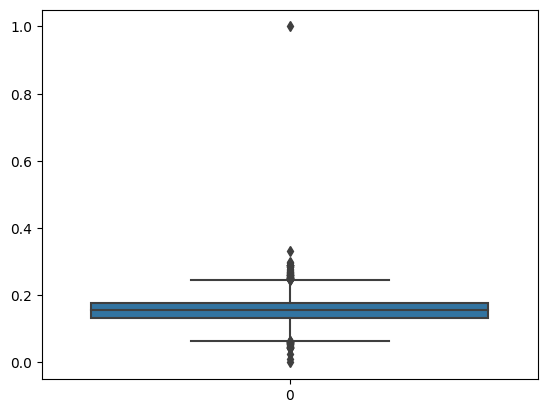

In [548]:
# Remove noise using Boxplot
# Finding the outliers 
import seaborn as sns

# Plot the boxplot of all columns
sns.boxplot(dataset['Tb'])

# Calculate the upper and lower bounds for each column using the interquartile range (IQR)
Q1 = dataset.quantile(0.25)
Q3 = dataset.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

# Drop the rows containing the outliers in each column
dataset = dataset[~((dataset < lower_bound) | (dataset > upper_bound)).any(axis=1)]

In [549]:
# Train test split 
Train_set, Test_set = train_test_split(dataset, test_size=0.10, shuffle=True, random_state=seed)
Train_set = Train_set.reset_index(drop=True)
Test_set = Test_set.reset_index(drop=True)
val_set,_ = train_test_split(dataset, test_size=0.5, shuffle=True, random_state=seed)
val_set = val_set.reset_index(drop=True)
Train_set

,Smiles,Tb
0,CCCCC(C(=O)OCC)C(=O)OCC,0.173717
1,Brc1cnc2ccccc2c1,0.189023
2,BrC(C)C(Br)(Br)C,0.160861
3,OCCC(C)CCCC(O)(C)C,0.184941
4,OCCCCCCCCCCCCCCCC,0.213103
...,...,...
4556,OC(C)CC(O)(C)C,0.157596
4557,CC1=COC=N1,0.112700
4558,Clc1ccc(C)cc1,0.143066
4559,CCCCCC(C)CCC,0.144413


In [550]:
train_mols = make_mol(Train_set)
test_mols = make_mol(Test_set)
val_mols = make_mol(val_set)

train_X = make_vec(train_mols)
test_X = make_vec(test_mols)
val_X = make_vec(val_mols)

#call_pca(train_mols)

In [551]:
# Model activation

model = GCN_Model_reg(args)
model = model.to(device)

In [552]:
# Printing the model structure
print(model)

GCN_Model_reg(
  (conv): GCNlayer(
    (convs): ModuleList(
      (0): NNConv(128, 128, aggr=add, nn=Sequential(
        (0): Linear(in_features=6, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=16384, bias=True)
      ))
      (1): NNConv(128, 128, aggr=add, nn=Sequential(
        (0): Linear(in_features=6, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=16384, bias=True)
      ))
    )
    (bns): ModuleList(
      (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (gru): ModuleList(
      (0): GRU(128, 128)
      (1): GRU(128, 128)
    )
    (lin0): Linear(in_features=30, out_features=128, bias=True)
    (conv_last): GraphConv(128, 128)
    (bn_last): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): FClay

In [553]:
train_loader = DataLoader(train_X, batch_size=64, shuffle=True, drop_last=True)
val_loader=DataLoader(val_X, batch_size=len(val_X), shuffle=False, drop_last=True)
test_loader = DataLoader(test_X, batch_size=len(test_X), shuffle=False, drop_last=True)

In [554]:
# Save Checkpoint for model evaluation :
def save_checkpoint(epoch, model, optimizer, filename):
    state = {'Epoch': epoch,'State_dict': model.state_dict(),'optimizer': optimizer.state_dict()}
    torch.save(model, filename)

In [555]:
def R2_score(y_pred_i,Y):
    #Next we shall compute sigma_yy, which is the variance of y 
    sigma_yy = 0
    for i in range(Y.shape[0]): #access each row from the data set 
       y_i = float(Y[i])
       sigma_yy += (y_i-Y.mean())**2

    #now we can compute sum of squared residuals 
    #print('sigma_yy:', sigma_yy)
    sum_sq_residuals=0
    for i in range(Y.shape[0]): #access each row from the data set 
         y_i = Y[i] #access i-th row of y
         e_i = y_i - y_pred_i[i] #compute the difference between the actual observation y_i and prediction y_pred_i

         sum_sq_residuals += (e_i)**2

    #print('sum of squared residuals:', sum_sq_residuals)

    #Then we will compute the R^2 quantity
    R_sq = 1-sum_sq_residuals/sigma_yy
    return R_sq

In [556]:
#from sklearn.metrics import r2_score

def train(model, device, optimizer, train_loader, criterion, args):
    train_correct = 0
    train_total = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)
        targets = data.y.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        
        #print(outputs)
        #print(targets)
        outputs.require_grad = False
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)

        correct_dim_output=outputs.squeeze() # done to reshape the outputs and match with targets
        score=R2_score(correct_dim_output.detach().cpu().numpy(), targets.detach().cpu().numpy())
        loss = criterion(correct_dim_output, targets)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_train_loss /= len(train_loader)
    #print('- Loss : %.4f' % epoch_train_loss)
    return model, epoch_train_loss,score

In [557]:
def test(model, device, test_loader, args):
    train_total = 0
    y_score=[]
    y_test=[]
    with torch.no_grad():
     for i, data in enumerate(test_loader):
        data = data.to(device)
        targets = data.y.to(device)
        outputs = model(data)
        #print(outputs)
        #print(targets)
        outputs.require_grad = False
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)

        correct_dim_output=outputs.squeeze() # done to reshape the outputs and match with targets
        #y_score.append(outputs.cpu().numpy())
        #y_test.append(targets.cpu().numpy())
        test_score=R2_score(outputs.cpu().numpy(),targets.cpu().numpy())
        print("R2 Score Validation test set:",R2_score(outputs.cpu().numpy(),targets.cpu().numpy()))
    return test_score,model,outputs.cpu().numpy(),targets.cpu().numpy()

In [558]:
def experiment(model, train_loader, device, args):

    
    optimizer = optim.Adam(model.parameters(), lr=args.lr,weight_decay=5e-4) # Add l2 regularizer ??  # ,weight_decay=0.001
    criterion = nn.HuberLoss() # decide on type of losses later
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
    
    list_train_loss = list()
    print('[Train]')
    counter=0
    train_r2_score=0.90
    val_r2_score=0.86
    for epoch in range(args.epoch):
        model.train()
        model, train_loss,score= train(model, device, optimizer, train_loader, criterion, args)
        print('- Epoch :', epoch+1,'- Loss : %.5f' % train_loss,'- Train R2 score : %.4f' % score)
        list_train_loss.append(train_loss)

        # Learning rate Updatation scheme when loss not decreasing
        if(epoch!=0):
            #print(train_loss[int(epoch)],train_loss[int(epoch-1)])
            if(round(list_train_loss[epoch],5)>=round(list_train_loss[epoch-1],5)):
                counter+=1
            else:
                counter=0
        if(train_loss<0.0002 and counter>=10):
           counter=0
           args.lr = optimizer.param_groups[0]['lr']*0.5
           print("\nLearning rate changed :",args.lr)
           optimizer = optim.Adam(model.parameters(), lr=args.lr,weight_decay=5e-4)
           scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)


        val_score,_,_,_=test(model, device,test_loader, args)

        # Saving the best model which has the highest R2 value
        if(val_score>val_r2_score):  # and score>train_r2_score  # Changed
            val_r2_score=val_score
            train_r2_score=score   
            print("Saving Model of score:",val_score,score)       
            save_checkpoint(epoch, model, optimizer, 'ECC_model.pt')  # Saving the best model
            
        scheduler.step()
    
    return args

In [559]:
result = vars(experiment(model, train_loader, device, args))

[Train]
- Epoch : 1 - Loss : 0.03832 - Train R2 score : -28.7484
R2 Score Validation test set: [-15.622374]
- Epoch : 2 - Loss : 0.00884 - Train R2 score : -11.2515
R2 Score Validation test set: [-7.7561874]
- Epoch : 3 - Loss : 0.00477 - Train R2 score : -11.4533
R2 Score Validation test set: [-4.648004]
- Epoch : 4 - Loss : 0.00331 - Train R2 score : -5.4598
R2 Score Validation test set: [-2.588473]
- Epoch : 5 - Loss : 0.00260 - Train R2 score : -2.5183
R2 Score Validation test set: [-2.523067]
- Epoch : 6 - Loss : 0.00205 - Train R2 score : -1.5833
R2 Score Validation test set: [-1.2986631]
- Epoch : 7 - Loss : 0.00178 - Train R2 score : -2.0824
R2 Score Validation test set: [-1.5286028]
- Epoch : 8 - Loss : 0.00155 - Train R2 score : -1.0566
R2 Score Validation test set: [-1.9633834]
- Epoch : 9 - Loss : 0.00126 - Train R2 score : -1.7601
R2 Score Validation test set: [-1.0675421]
- Epoch : 10 - Loss : 0.00121 - Train R2 score : -1.2852
R2 Score Validation test set: [-1.0043263]
-

c:\Users\kanad\Desktop\Github repos\ME_793_PROJECT\793_env\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


- Epoch : 302 - Loss : 0.00004 - Train R2 score : 0.9263
R2 Score Validation test set: [0.9345379]
Saving Model of score: [0.9345379] 0.9263255683244618
- Epoch : 303 - Loss : 0.00005 - Train R2 score : 0.8093
R2 Score Validation test set: [0.9261143]
- Epoch : 304 - Loss : 0.00004 - Train R2 score : 0.8833
R2 Score Validation test set: [0.93531615]
Saving Model of score: [0.93531615] 0.8833313211949362
- Epoch : 305 - Loss : 0.00004 - Train R2 score : 0.9439
R2 Score Validation test set: [0.93016267]
- Epoch : 306 - Loss : 0.00004 - Train R2 score : 0.8480
R2 Score Validation test set: [0.93064094]
- Epoch : 307 - Loss : 0.00004 - Train R2 score : 0.8952
R2 Score Validation test set: [0.92960376]
- Epoch : 308 - Loss : 0.00004 - Train R2 score : 0.9083
R2 Score Validation test set: [0.9278077]
- Epoch : 309 - Loss : 0.00004 - Train R2 score : 0.9133
R2 Score Validation test set: [0.9298914]
- Epoch : 310 - Loss : 0.00004 - Train R2 score : 0.8483
R2 Score Validation test set: [0.93160

In [560]:
import gc

torch.cuda.empty_cache()
gc.collect()

6725

In [561]:
model=torch.load('ECC_model.pt')

In [562]:
device=torch.device('cpu')
model=model.to(device)

R2 Score Validation test set: [0.93557024]


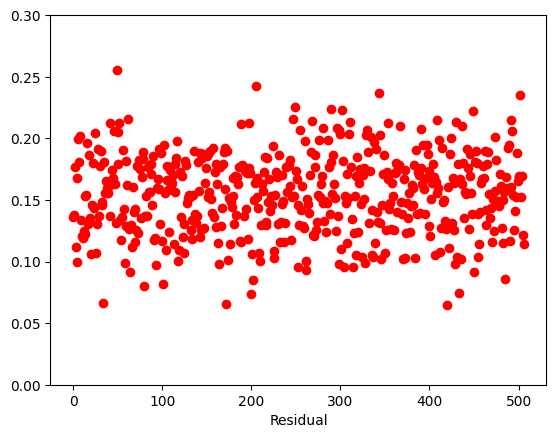

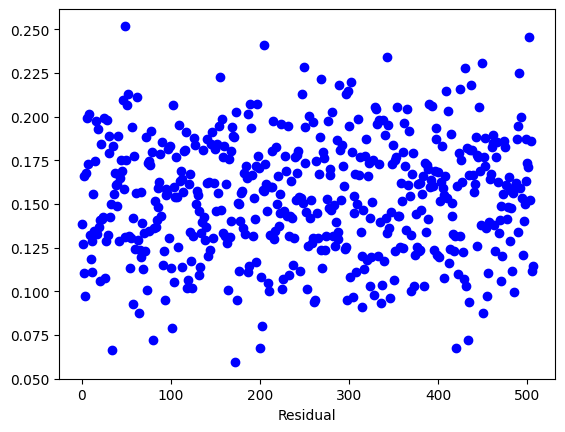

(507, 1) (507, 1)


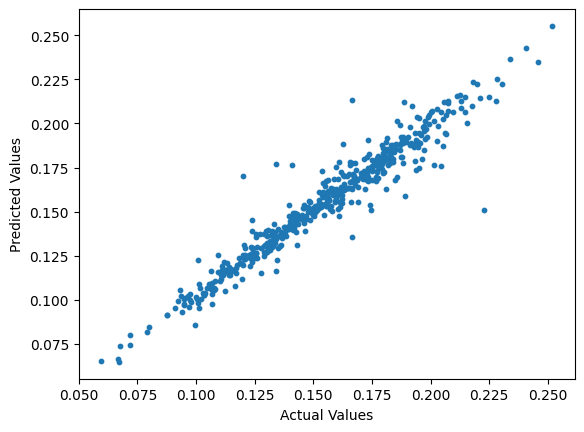

In [577]:
import matplotlib.pyplot as plt
test_score,model,y_score,y_test=test(model, device,test_loader, args)
y_test=y_test.reshape(y_test.shape[0],1)
output_test=[]
target_test=[]
for i in range(y_score.shape[0]):
    output_test.append(y_score[i][0])
    target_test.append(y_test[i][0])
#print(output_test)
# y_score is in the form of torch tensor. So not converted to numpy properly
x=np.array([i for i in range(len(y_score))])
#print(len(x),y_score[0])
#print(y_score,x.shape)
#target=list(y_test[0])

plt.ylim(0,0.3)
plt.scatter(x,y=output_test,color='red',label='Predicted')
plt.xlabel("Residual")
plt.show()
plt.scatter(x,y=target_test,color='blue',label='Actual Values')
plt.xlabel("Residual")
plt.show()

print(y_test.shape,y_score.shape)
plt.scatter(target_test,output_test,s=10)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

In [578]:
# converting data to actual boiling points
#print(y_score[0][0])
for i in range(len(output_test)):
    # predicted
    output_test[i]=output_test[i]*(max_val-min_val)+min_val
    output_test[i]=output_test[i]*std+mean

    # Actual
    target_test[i]=target_test[i]*(max_val-min_val)+min_val
    target_test[i]=target_test[i]*std+mean

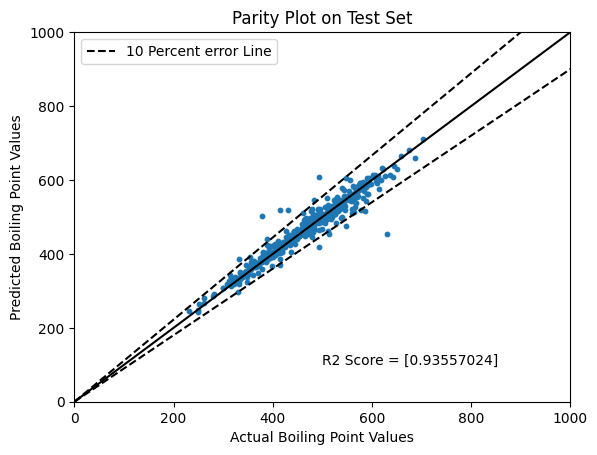

In [579]:
plt.scatter(target_test,output_test,s=10)
plt.plot([0,1000],[0,1000],color='black')
plt.plot([0,900],[0,1000],color='black',linestyle='dashed',label='10 Percent error Line') # +10 % error
plt.plot([0,1000],[0,900],color='black',linestyle='dashed') # -10 % error
plt.xlabel("Actual Boiling Point Values")
plt.ylabel("Predicted Boiling Point Values")
plt.ylim(0,1000)
plt.xlim(0,1000)
plt.legend()
plt.title('Parity Plot on Test Set')
plt.text(500,100,s=f'R2 Score = {test_score}')
plt.show()

In [580]:
# Save test 
test_data= pd.DataFrame()
test_data['ECC Outliers removed Actual Boiling Point']=target_test
test_data['ECC Outliers removed Predicted Boiling Point']=output_test
test_data.to_csv('../data/Results/ECC_ Outliers_pytorch_Test_values.csv')


In [581]:
# Train set predictions save
train_loader_pred = DataLoader(train_X, batch_size=len(train_X), shuffle=False, drop_last=True)
len(train_X)

4561

In [582]:
import gc

torch.cuda.empty_cache()
gc.collect()

23394

R2 Score Validation test set: [0.9617675]
4561


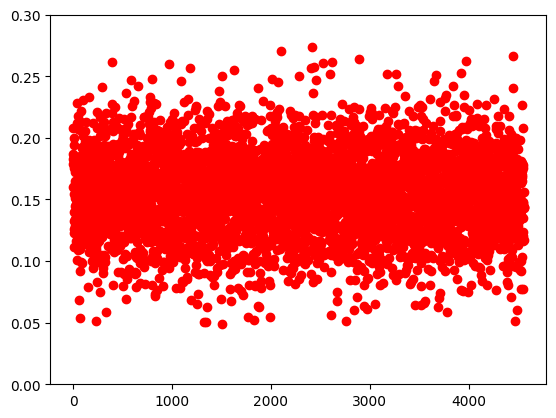

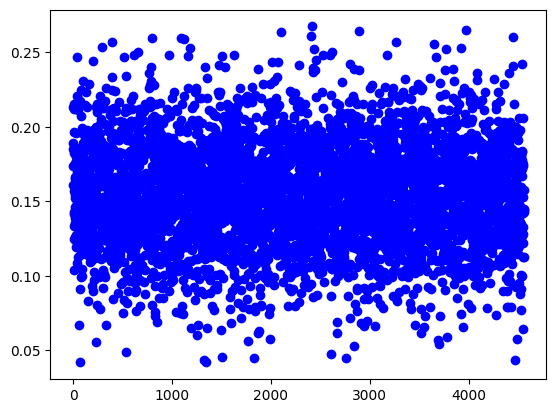

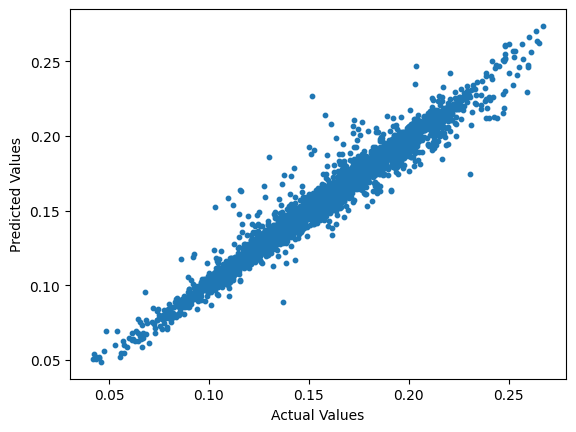

In [583]:
import matplotlib.pyplot as plt
train_score,model,y_score,y_test=test(model, device,train_loader_pred, args)
y_test=y_test.reshape(y_test.shape[0],1)
output_test=[]
target_test=[]
for i in range(y_score.shape[0]):
    output_test.append(y_score[i][0])
    target_test.append(y_test[i][0])
print(len(output_test))
# y_score is in the form of torch tensor. So not converted to numpy properly
x=np.array([i for i in range(len(y_score))])
#print(len(x),y_score[0])
#print(y_score,x.shape)
#target=list(y_test[0])

plt.ylim(0,0.3)
plt.scatter(x,y=output_test,color='red',label='Predicted')
plt.show()
plt.scatter(x,y=target_test,color='blue',label='Actual Values')
plt.show()

#print(y_test.shape,y_score.shape)
plt.scatter(target_test,output_test,s=10)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

In [584]:
# converting data to actual boiling points
#print(y_score[0][0])
for i in range(len(output_test)):
    # predicted
    output_test[i]=output_test[i]*(max_val-min_val)+min_val
    output_test[i]=output_test[i]*std+mean

    # Actual
    target_test[i]=target_test[i]*(max_val-min_val)+min_val
    target_test[i]=target_test[i]*std+mean

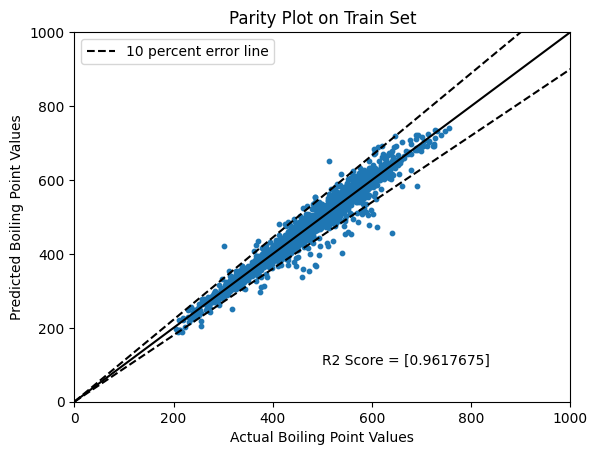

In [587]:
plt.scatter(output_test,target_test,s=10)
plt.plot([0,1000],[0,1000],color='black')
plt.plot([0,900],[0,1000],color='black',linestyle='dashed',label='10 percent error line') # +10 % error
plt.plot([0,1000],[0,900],color='black',linestyle='dashed') # -10 % error
plt.ylim(0,1000)
plt.xlim(0,1000)
plt.xlabel("Actual Boiling Point Values")
plt.ylabel("Predicted Boiling Point Values")
plt.text(500,100,s=f'R2 Score = {train_score}')
plt.legend()
plt.title('Parity Plot on Train Set')
plt.show()

In [586]:
# Save train
test_data= pd.DataFrame()
test_data['ECC Outliers removed Actual Boiling Point']=target_test
test_data['ECC Outliers removed Predicted Boiling Point']=output_test
test_data.to_csv('../data/Results/ECC_ Outliers_pytorch_Train_values.csv')
